In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import holidays
from scipy.fftpack import fft#푸리에 변환을 위한 코드입니다.
from scipy.stats import boxcox#박스콕스 변환을 위한 코드임
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# ===== LightGBM 머신러닝 파이프라인 =====
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
import optuna
from optuna.samplers import TPESampler



from sklearn.svm import SVR
#기타
import warnings
warnings.filterwarnings('ignore')

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
df_train = pd.read_csv("train_heat.csv")
df_test = pd.read_csv("test_heat.csv")
#열이름빼기
df_train.columns = df_train.columns.str.replace('train_heat.', '', regex=False)
#Unnamed:0제거
df_train = df_train.drop(columns=["Unnamed: 0"])
#test데이터 열이름 바꾸기
df_test.columns = [
    "tm", "branch_id", "ta", "wd", "ws",
    "rn_day", "rn_hr1", "hm", "si", "ta_chi","heat_demand"]



def calculate_summer_apparent_temp(ta, hm):
    """여름철 체감온도 계산"""
    try:
        tw = ta * np.arctan(0.151977 * np.sqrt(hm + 8.313659)) \
             + np.arctan(ta + hm) \
             - np.arctan(hm - 1.676331) \
             + 0.00391838 * hm**1.5 * np.arctan(0.023101 * hm) \
             - 4.686035
        return -0.2442 + 0.55399 * tw + 0.45535 * ta - 0.0022 * tw**2 + 0.00278 * tw * ta + 3.0
    except:
        return np.nan

def calculate_winter_apparent_temp(ta, ws):
    """겨울철 체감온도 계산"""
    try:
        v = ws * 3.6  # m/s → km/h
        return 13.12 + 0.6215 * ta - 11.37 * v**0.16 + 0.3965 * ta * v**0.16
    except:
        return np.nan

def add_apparent_temp_features(df):
    df['month'] = df['tm'].dt.month
    df['apparent_temp'] = df.apply(lambda row:
        calculate_summer_apparent_temp(row['ta'], row['hm']) if 5 <= row['month'] <= 9
        else calculate_winter_apparent_temp(row['ta'], row['ws']),
        axis=1
    )
    return df


def branchwise_svr_impute(df, col, time_col='tm'):
    df = df.copy()
    # 시간 컬럼을 숫자형으로 변환 (timestamp, 초 단위)
    df['_time_num'] = pd.to_datetime(df[time_col]).astype(np.int64) // 10**9
    # branch별로 SVR 보간
    def impute_group(g):
        return svr_impute_series(g[col], g['_time_num'])
    # apply 결과를 원래 인덱스에 맞게 할당
    df[col] = df.groupby('branch_id', group_keys=False).apply(impute_group)
    df = df.drop(columns=['_time_num'])
    return df


def preprocess_weather_data(df):
    # 날짜 변환
    df['tm'] = pd.to_datetime(df['tm'], format='%Y%m%d%H')
    # 1. si: 08~18시가 아닐 때 -99는 0으로
    mask_outside_8_to_18 = (~df['tm'].dt.hour.between(8, 18)) & (df['si'] == -99)
    df.loc[mask_outside_8_to_18, 'si'] = 0

    # 2. wd에서 9.9는 NaN으로
    df['wd'] = df['wd'].replace(9.9, np.nan)

    # 3. -99 처리
    df.replace(-99, np.nan, inplace=True)


    # SVR 보간
    df = df.sort_values(['branch_id', 'tm'])

    numeric_cols = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']

    for branch in df['branch_id'].unique():
        print(f"   🏢 브랜치 {branch} SVR 보간 중...", end=" ")
        
        branch_mask = df['branch_id'] == branch
        branch_data = df[branch_mask].copy()

        # 시간 특성 생성
        branch_data['hour'] = branch_data['tm'].dt.hour
        branch_data['day_of_year'] = branch_data['tm'].dt.dayofyear
        branch_data['month'] = branch_data['tm'].dt.month

        for col in numeric_cols:
            if col in branch_data.columns:
                missing_mask = branch_data[col].isna()

                if missing_mask.sum() > 0:
                    train_mask = ~missing_mask

                    # 예측할 데이터 준비
                    X_train = branch_data.loc[train_mask, ['hour', 'day_of_year', 'month']].values
                    y_train = branch_data.loc[train_mask, col].values
                    X_pred = branch_data.loc[missing_mask, ['hour', 'day_of_year', 'month']].values

                    try:
                        scaler_X = StandardScaler()
                        scaler_y = StandardScaler()

                        X_train_scaled = scaler_X.fit_transform(X_train)
                        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

                        svr = SVR(kernel='rbf', C=1.0, gamma='scale')
                        svr.fit(X_train_scaled, y_train_scaled)

                        X_pred_scaled = scaler_X.transform(X_pred)
                        y_pred_scaled = svr.predict(X_pred_scaled)
                        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

                        # 보간 결과 반영
                        df.loc[branch_mask & missing_mask, col] = y_pred

                    except Exception as e:
                        print(f"\n   ⚠️ {col} SVR 실패 → 선형 보간 대체")
                        df.loc[branch_mask, col] = df.loc[branch_mask, col].interpolate(method='linear')

                # 남은 결측 ffill/bfill로 제거
                df.loc[branch_mask, col] = df.loc[branch_mask, col].fillna(method='ffill').fillna(method='bfill')

        print("✅")

    print("🎉 SVR 보간 완료 (조건 없이 전부 시도)")
    #보간후 음수나올 가능성존재
    df.loc[df['ta'] < 0, 'ta'] = 0
    df.loc[df['ws'] < 0, 'ws'] = 0

    # 📌 파생 변수 생성
    df['year'] = df['tm'].dt.year
    df['month'] = df['tm'].dt.month
    df['hour'] = df['tm'].dt.hour
    df['date'] = df['tm'].dt.date
    df['weekday'] = df['tm'].dt.weekday
    df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)

    # 🇰🇷 한국 공휴일
    kr_holidays = holidays.KR()
    df['is_holiday'] = df['tm'].dt.date.apply(lambda x: int(x in kr_holidays))

    # 🕒 시간 지연
    for lag in [1, 2, 3]:
        df[f'ta_lag_{lag}'] = df.groupby('branch_id')['ta'].shift(lag)
        df[f'ta_lag_{lag}'] = df.groupby('branch_id')[f'ta_lag_{lag}'].transform(
        lambda x: x.fillna(method='bfill'))
    # 🔥 HDD / CDD
    df['HDD18'] = np.maximum(0, 18 - df['ta'])
    #df['CDD18'] = np.maximum(0, df['ta'] - 18)
    df['HDD20'] = np.maximum(0, 20 - df['ta'])
    #df['CDD20'] = np.maximum(0, df['ta'] - 20)

    #직접만든 체감온도
    df = add_apparent_temp_features(df)


    # 지점별 온도 편차
    branch_mean = df.groupby('branch_id')['ta'].transform('mean')
    df['branch_temp_abs_deviation'] = np.abs(df['ta'] - branch_mean)



    # 이동 평균 (3시간 단위 최대 24시간 = 8개)
    for n in [3, 6, 9, 12, 15, 18, 21, 24]:
        df[f'ta_3h_avg_{n}'] = df.groupby('branch_id')['ta'].transform(lambda x: x.rolling(n, min_periods=1).mean())

    # 불쾌지수
    df['DCI'] = 0.81 * df['ta'] + 0.01 * df['hm'] * (0.99 * df['ta'] - 14.3) + 46.3

    # 풍속 냉지수 (wchi)
    ws_kmh = df['ws'] * 3.6  # m/s -> km/h 변환
    df['wchi'] = 13.12 + 0.6215 * df['ta'] - 11.37 * ws_kmh**0.16 + 0.3965 * df['ta'] * ws_kmh**0.16

     # 풍속 고려 체감온도 (wind chill)
    df['wind_chill'] = 13.12 + 0.6215 * df['ta'] - 11.37 * df['ws']**0.16 + 0.3965 * df['ta'] * df['ws']**0.16

    # 실효온도
    df['e'] = (df['hm'] / 100) * 6.105 * np.exp((17.27 * df['ta']) / (237.7 + df['ta']))
    df['atemphi'] = df['ta'] + 0.33 * df['e'] - 0.70 * df['ws'] - 4.00

    # 주기성 인코딩
    df['dayofyear'] = df['tm'].dt.dayofyear
    df['dayofmonth'] = df['tm'].dt.day
    df['weekofyear'] = df['tm'].dt.isocalendar().week.astype(int)

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)

    # 하루 5구간
    def time_slot(h): return int(h // 5)
    df['hour_slot_5'] = df['hour'].apply(time_slot)

    def compute_fft_feature(series, n=10):
        fft_vals = np.abs(fft(series.fillna(0)))
        # 인덱스 이름을 명확히 지정
        s = pd.Series(fft_vals[:n], index=[f'fft_{i}' for i in range(n)])
        return s

    def compute_fft_feature(series, n=10):
        fft_vals = np.abs(fft(series.fillna(0)))
        s = pd.Series(fft_vals[:n], index=pd.Index([f'fft_{i}' for i in range(n)], name='fft_idx'))
        return s

    fft_cols = ['ta', 'hm', 'ws', 'ta_chi', 'apparent_temp']
    fft_features = []
    branch_ids = df['branch_id'].unique()
    fft_feature_dict = {bid: {} for bid in branch_ids}
    for col in fft_cols:
        if col not in df.columns:
            continue
        for branch_id in branch_ids:
            arr = df.loc[df['branch_id'] == branch_id, col].fillna(0).values
            fft_vals = np.abs(fft(arr))[:10]
            for i, val in enumerate(fft_vals):
                fft_feature_dict[branch_id][f'Nph_{col}_{i}'] = val
                
    # DataFrame으로 변환
    fft_features_df = pd.DataFrame.from_dict(fft_feature_dict, orient='index')
    # 원본 df와 merge
    df = df.merge(fft_features_df, left_on='branch_id', right_index=True, how='left')

    # 기온 차분
    df['ta_diff_6h'] = df.groupby('branch_id')['ta'].diff(6).bfill()
    df['ta_diff_12h'] = df.groupby('branch_id')['ta'].diff(12).bfill()
    df['ta_diff_24h'] = df.groupby('branch_id')['ta'].diff(24).bfill()

    # 일교차
    df['day_ta_max'] = df.groupby(['branch_id', df['tm'].dt.date])['ta'].transform('max')
    df['day_ta_min'] = df.groupby(['branch_id', df['tm'].dt.date])['ta'].transform('min')
    df['daily_range'] = df['day_ta_max'] - df['day_ta_min']

    # 일교차 변화량
    df['daily_range_shift'] = df.groupby('branch_id')['daily_range'].shift(1).bfill()

    # 피크타임1
    df['peak_time1'] = 0
    df.loc[(df['hour'] >= 0) & (df['hour'] <= 6), 'peak_time1'] = 1
    df.loc[(df['hour'] > 6) & (df['hour'] <= 11), 'peak_time1'] = 2
    df.loc[(df['hour'] > 11) & (df['hour'] <= 18), 'peak_time1'] = 3
    df.loc[(df['hour'] > 18) & (df['hour'] <= 23), 'peak_time1'] = 4

    # 피크타임2
    df['peak_time2'] = 0
    df.loc[(df['hour'] >= 2) & (df['hour'] <= 10), 'peak_time2'] = 1


    # heating season
    df['heating_season'] = df['month'].isin([10,11,12,1, 2, 3,4]).astype(int)

    # 온도 범주화
    df['temp_category20'] = pd.cut(df['ta'], bins=[-np.inf, 20, np.inf], labels=['low', 'high'])
    df['temp_category18'] = pd.cut(df['ta'], bins=[-np.inf, 18, np.inf], labels=['low', 'high'])
    df['temp_category16'] = pd.cut(df['ta'], bins=[-np.inf, 16, np.inf], labels=['low', 'high'])

    # 오전/오후
    df['afternoon'] = (df['hour'] >= 12).astype(int)

    # 계절
    def get_season(month):
        return {
            12: 'winter', 1: 'winter', 2: 'winter',
            3: 'spring', 4: 'spring', 5: 'spring',
            6: 'summer', 7: 'summer', 8: 'summer',
            9: 'fall', 10: 'fall', 11: 'fall'
        }.get(month, 'unknown')
    df['season'] = df['month'].apply(get_season)

    # 한파 주의보/경보
    df['cold_watch'] = (df['ta'] <= -12).astype(int)  # 주의보
    df['cold_warning'] = (df['ta'] <= -15).astype(int)  # 경보


    # 변환 대상 변수
    col = 'ta'
    '''
    df['ta_boxcox'] = np.nan
    df['ta_boxcox_lambda'] = np.nan
    df['ta_boxcox_shift'] = np.nan  # shift 값도 저장
    for branch, group in df.groupby('branch_id'):
        col = 'ta'
        min_val = group[col].min()
        if min_val <= 0:
            shift = abs(min_val) + 1e-4
        else:
            shift = 0
        shifted = group[col] + shift
        shifted = shifted.dropna()
        if shifted.nunique() > 1 and len(shifted) >= 2:
            transformed, fitted_lambda = boxcox(shifted)
            df.loc[shifted.index, 'ta_boxcox'] = transformed
            df.loc[shifted.index, 'ta_boxcox_lambda'] = fitted_lambda
            df.loc[shifted.index, 'ta_boxcox_shift'] = shift
        else:
            df.loc[group.index, 'ta_boxcox'] = np.nan
            df.loc[group.index, 'ta_boxcox_lambda'] = np.nan
            df.loc[group.index, 'ta_boxcox_shift'] = shift


    '''
    df = df.drop(columns=['month','hour','date'])



    return df
#상호작용 처리못함
#군집화된 전처리 못함


#정규화 일단 min max +원핫인코딩
def scale_encode(df):
    cat_cols = [
         'peak_time1', 'peak_time2', 'heating_season',
        'temp_category16', 'temp_category18', 'temp_category20',
        'afternoon', 'season'
    ]

    # 범주형 변수 category화
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')

    # 원-핫 인코딩
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # 연속형 변수만 추출 (타겟, 날짜 등 제외)
    exclude_cols = ['heat_demand', 'peak_time1', 'peak_time2', 'heating_season',
        'temp_category16', 'temp_category18', 'temp_category20','afternoon', 'season']
    num_cols = [col for col in df.columns
                if (df[col].dtype in [np.float64, np.int64]) and (col not in exclude_cols)]

    # MinMaxScaler 적용
    scaler = MinMaxScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])


    return df



df_train = preprocess_weather_data(df_train)
df_test = preprocess_weather_data(df_test)


df_train = scale_encode(df_train)
df_test = scale_encode(df_test)

df_train.to_csv('df_train_prescale.csv', index=True)
df_test.to_csv('df_test_prescale.csv', index=True)

   🏢 브랜치 A SVR 보간 중... ✅
   🏢 브랜치 B SVR 보간 중... ✅
   🏢 브랜치 C SVR 보간 중... ✅
   🏢 브랜치 D SVR 보간 중... ✅
   🏢 브랜치 E SVR 보간 중... ✅
   🏢 브랜치 F SVR 보간 중... ✅
   🏢 브랜치 G SVR 보간 중... ✅
   🏢 브랜치 H SVR 보간 중... ✅
   🏢 브랜치 I SVR 보간 중... ✅
   🏢 브랜치 J SVR 보간 중... ✅
   🏢 브랜치 K SVR 보간 중... ✅
   🏢 브랜치 L SVR 보간 중... ✅
   🏢 브랜치 M SVR 보간 중... ✅
   🏢 브랜치 N SVR 보간 중... ✅
   🏢 브랜치 O SVR 보간 중... ✅
   🏢 브랜치 P SVR 보간 중... ✅
   🏢 브랜치 Q SVR 보간 중... ✅
   🏢 브랜치 R SVR 보간 중... ✅
   🏢 브랜치 S SVR 보간 중... ✅
🎉 SVR 보간 완료 (조건 없이 전부 시도)
   🏢 브랜치 A SVR 보간 중... 
   ⚠️ heat_demand SVR 실패 → 선형 보간 대체
✅
   🏢 브랜치 B SVR 보간 중... 
   ⚠️ heat_demand SVR 실패 → 선형 보간 대체
✅
   🏢 브랜치 C SVR 보간 중... 
   ⚠️ heat_demand SVR 실패 → 선형 보간 대체
✅
   🏢 브랜치 D SVR 보간 중... 
   ⚠️ heat_demand SVR 실패 → 선형 보간 대체
✅
   🏢 브랜치 E SVR 보간 중... 
   ⚠️ heat_demand SVR 실패 → 선형 보간 대체
✅
   🏢 브랜치 F SVR 보간 중... 
   ⚠️ heat_demand SVR 실패 → 선형 보간 대체
✅
   🏢 브랜치 G SVR 보간 중... 
   ⚠️ heat_demand SVR 실패 → 선형 보간 대체
✅
   🏢 브랜치 H SVR 보간 중... 
   ⚠️ heat_demand SVR 실패 → 선형 보간 대체
✅
   

In [4]:
df_train = pd.read_csv('df_train_prescale.csv')
df=df_train.copy()
df_train = df[df['year'] <= 2022]
df_test = df[df['year'] >= 2023]
df_train = df_train.sort_values(['branch_id', 'tm'])
df_test = df_test.sort_values(['branch_id', 'tm'])
df_train = df_train.drop(columns=['year'])
df_train = df_train.drop(columns=['Unnamed: 0'])
df_test = df_test.drop(columns=['year'])
df_test = df_test.drop(columns=['Unnamed: 0'])
df_train = df_train.set_index('tm')
df_test = df_test.set_index('tm')
df_train = df_train.sort_index()
df_test = df_test.sort_index()

In [5]:
def run_3fold_pipeline_with_residual(df_train, df_test, target_col='heat_demand'):
    features = [col for col in df_train.columns if col != target_col]
    X = df_train[features]
    y = df_train[target_col]

    n = len(df_train)
    fold_size = n // 3

    val_rmses = []
    test_preds = []

    print(f"전체 데이터 길이: {n}, Fold 크기: {fold_size}\n")

    for fold in range(2):  # Fold 0, 1 수행 (3번째는 테스트용 데이터 분리)
        train_end = fold_size * (fold + 1)
        val_end = fold_size * (fold + 2)

        X_train = X.iloc[:train_end]
        y_train = y.iloc[:train_end]
        X_val = X.iloc[train_end:val_end]
        y_val = y.iloc[train_end:val_end]

        print(f"===== Fold {fold+1} =====")
        print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}")

        # 1) LightGBM 베이지안 최적화 함수
        def lgb_objective(trial):
            params = {
                'objective': 'regression',
                'metric': 'rmse',
                'boosting_type': 'gbdt',
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'num_leaves': trial.suggest_int('num_leaves', 10, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
                'n_estimators': 1000,
                'random_state': 42,
                'n_jobs': -1
            }
            model = lgb.LGBMRegressor(**params)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
            )
            val_pred = model.predict(X_val)
            return np.sqrt(mean_squared_error(y_val, val_pred))

        lgb_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        lgb_study.optimize(lgb_objective, n_trials=20, show_progress_bar=True)

        best_lgb_params = lgb_study.best_params
        best_lgb_params.update({
            'objective': 'huber',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'n_estimators': 1000,
            'random_state': 42,
            'n_jobs': -1
        })

        # 2) LightGBM 최적 모델 학습
        lgb_model = lgb.LGBMRegressor(**best_lgb_params)
        lgb_model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
        )

        val_pred_lgb = lgb_model.predict(X_val)
        val_rmse_lgb = np.sqrt(mean_squared_error(y_val, val_pred_lgb))
        print(f"LightGBM Fold {fold+1} Validation RMSE: {val_rmse_lgb:.4f}")

        # 3) 잔차 계산
        residual_train = y_train - lgb_model.predict(X_train)
        residual_val = y_val - val_pred_lgb

        # 4) XGBoost 베이지안 최적화 함수
        def xgb_objective(trial):
            params = {
                'objective': 'reg:squarederror',  # Huber-like loss
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 2, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
                'random_state': 42,
                'n_jobs': -1
            }
            model = xgb.XGBRegressor(**params)
            model.fit(
                X_train, residual_train,
                eval_set=[(X_val, residual_val)],
                verbose=0
            )
            val_pred = model.predict(X_val)
            return np.sqrt(mean_squared_error(residual_val, val_pred))

        xgb_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        xgb_study.optimize(xgb_objective, n_trials=20, show_progress_bar=True)

        best_xgb_params = xgb_study.best_params
        best_xgb_params.update({
            'objective': 'reg:pseudohubererror',
            'random_state': 42,
            'n_jobs': -1
        })

        # 5) XGBoost 최적 모델 학습 (잔차 예측용)
        xgb_model = xgb.XGBRegressor(**best_xgb_params)
        xgb_model.fit(
            X_train, residual_train,
            eval_set=[(X_val, residual_val)],
            verbose=100
        )

        val_pred_residual = xgb_model.predict(X_val)
        val_pred_final = val_pred_lgb + val_pred_residual
        val_rmse_final = np.sqrt(mean_squared_error(y_val, val_pred_final))
        print(f"Residual Stacking Fold {fold+1} Validation RMSE: {val_rmse_final:.4f}")

        val_rmses.append(val_rmse_final)

        # 테스트는 마지막에 평균 예측 위해 저장
        test_pred_lgb = lgb_model.predict(df_test[features])
        test_pred_residual = xgb_model.predict(df_test[features])
        test_pred_fold = test_pred_lgb + test_pred_residual
        test_preds.append(test_pred_fold)

        print("-----------------------------")

    avg_val_rmse = np.mean(val_rmses)
    avg_test_pred = np.mean(test_preds, axis=0)

    print(f"\n최종 평균 Validation RMSE: {avg_val_rmse:.4f}")

    df_test[target_col] = avg_test_pred

    return {
        'val_rmse': avg_val_rmse,
        'val_rmses': val_rmses,   # 추가!
        'test_pred': avg_test_pred,
        'test_index': df_test.index
    }

[I 2025-06-22 02:18:19,902] A new study created in memory with name: no-name-f070c08f-9e7e-4725-829a-9184b18f8441


전체 데이터 길이: 17519, Fold 크기: 5839

===== Fold 1 =====
Train size: 5839, Validation size: 5839


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is s

Best trial: 0. Best value: 17.2628:   5%|▌         | 1/20 [00:00<00:07,  2.49it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 17.2628:  10%|█         | 2/20 [00:00<00:05,  3.57it/s]

[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.5274034664069657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274034664069657
[LightGBM] [Warning] bagging_fraction is set=0.5090949803242604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5090949803242604
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9322
[LightGBM] [Info] Number of data points in the train set: 5839, number of used features: 60
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.52740346

Best trial: 2. Best value: 16.697:  15%|█▌        | 3/20 [00:01<00:08,  1.95it/s] 

[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.5752867891211308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5752867891211308
[LightGBM] [Warning] bagging_fraction is set=0.619817105976215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.619817105976215
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[I 2025-06-22 02:18:21,288] Trial 2 finished with value: 16.696950187505283 and parameters: {'learning_rate': 0.04345454109729477, 'num_leaves': 94, 'max_depth': 10, 'min_data_in_leaf': 36, 'feature_fraction': 0.5752867891211308, 'bagging_fraction': 0.619817105976215, 'bagging_freq': 4, 'reg_alpha': 7.851759613930136, 'reg_lambda': 1.9967378215835974}. Best is trial 2 with value: 16.696950187505283.
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=

Best trial: 3. Best value: 16.5874:  20%|██        | 4/20 [00:01<00:06,  2.51it/s]

[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.502314474212375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.502314474212375
[LightGBM] [Warning] bagging_fraction is set=0.43903095579116774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43903095579116774
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[I 2025-06-22 02:18:21,509] Trial 3 finished with value: 16.587428992236475 and parameters: {'learning_rate': 0.05748924681991978, 'num_leaves': 182, 'max_depth': 3, 'min_data_in_leaf': 126, 'feature_fraction': 0.502314474212375, 'bagging_fraction': 0.43903095579116774, 'bagging_freq': 7, 'reg_alpha': 9.656320330745594, 'reg_lambda': 8.08397348116461}. Best is trial 3 with value: 16.587428992236475.
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_sampl

Best trial: 4. Best value: 16.0155:  25%|██▌       | 5/20 [00:02<00:11,  1.32it/s]

[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.47322294090686734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47322294090686734
[LightGBM] [Warning] bagging_fraction is set=0.6971061460667621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6971061460667621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-22 02:18:22,900] Trial 4 finished with value: 16.015509849683234 and parameters: {'learning_rate': 0.028180680291847244, 'num_leaves': 38, 'max_depth': 11, 'min_data_in_leaf': 94, 'feature_fraction': 0.47322294090686734, 'bagging_fraction': 0.6971061460667621, 'bagging_freq': 1, 'reg_alpha': 9.093204020787821, 'reg_lambda': 2.587799816000169}. Best is trial 4 with value: 16.015509849683234.
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_sa

Best trial: 4. Best value: 16.0155:  30%|███       | 6/20 [00:03<00:09,  1.47it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 4. Best value: 16.0155:  35%|███▌      | 7/20 [00:03<00:07,  1.80it/s]

[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.4271363733463229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4271363733463229
[LightGBM] [Warning] bagging_fraction is set=0.5951981984579586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5951981984579586
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[I 2025-06-22 02:18:23,734] Trial 6 finished with value: 16.268650881409116 and parameters: {'learning_rate': 0.0764136186923332, 'num_leaves': 278, 'max_depth': 4, 'min_data_in_leaf': 47, 'feature_fraction': 0.4271363733463229, 'bagging_fraction': 0.5951981984579586, 'bagging_freq': 3, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.287375091519294}. Best is trial 4 with value: 16.015509849683234.
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=

Best trial: 4. Best value: 16.0155:  40%|████      | 8/20 [00:04<00:08,  1.37it/s]

[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.8813181884524238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8813181884524238
[LightGBM] [Warning] bagging_fraction is set=0.44473038620786254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44473038620786254
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[I 2025-06-22 02:18:24,838] Trial 7 finished with value: 17.232822026614173 and parameters: {'learning_rate': 0.03364867144187954, 'num_leaves': 91, 'max_depth': 10, 'min_data_in_leaf': 36, 'feature_fraction': 0.8813181884524238, 'bagging_fraction': 0.44473038620786254, 'bagging_freq': 7, 'reg_alpha': 7.722447692966574, 'reg_lambda': 1.987156815341724}. Best is trial 4 with value: 16.015509849683234.
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_sam

Best trial: 4. Best value: 16.0155:  45%|████▌     | 9/20 [00:05<00:08,  1.24it/s]

[I 2025-06-22 02:18:25,820] Trial 8 finished with value: 17.312011798985814 and parameters: {'learning_rate': 0.010189592979395137, 'num_leaves': 247, 'max_depth': 12, 'min_data_in_leaf': 149, 'feature_fraction': 0.8627622080115674, 'bagging_fraction': 0.44442679104045424, 'bagging_freq': 3, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.631034258755935}. Best is trial 4 with value: 16.015509849683234.
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5951099932160482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951099932160482
[LightGBM] [Warning] bagging_fraction is set=0.8377637070028385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377637070028385
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_sa

Best trial: 9. Best value: 15.8387:  50%|█████     | 10/20 [00:06<00:06,  1.59it/s]

[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5951099932160482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951099932160482
[LightGBM] [Warning] bagging_fraction is set=0.8377637070028385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377637070028385
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[I 2025-06-22 02:18:26,040] Trial 9 finished with value: 15.838690273313492 and parameters: {'learning_rate': 0.08330803890301997, 'num_leaves': 106, 'max_depth': 3, 'min_data_in_leaf': 69, 'feature_fraction': 0.5951099932160482, 'bagging_fraction': 0.8377637070028385, 'bagging_freq': 5, 'reg_alpha': 8.872127425763265, 'reg_lambda': 4.722149251619493}. Best is trial 9 with value: 15.838690273313492.
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples

Best trial: 9. Best value: 15.8387:  55%|█████▌    | 11/20 [00:06<00:05,  1.76it/s]

[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] feature_fraction is set=0.7015187306048779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7015187306048779
[LightGBM] [Warning] bagging_fraction is set=0.9111852347596203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9111852347596203
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[I 2025-06-22 02:18:26,472] Trial 10 finished with value: 18.025655721703565 and parameters: {'learning_rate': 0.25954942002844333, 'num_leaves': 182, 'max_depth': 6, 'min_data_in_leaf': 76, 'feature_fraction': 0.7015187306048779, 'bagging_fraction': 0.9111852347596203, 'bagging_freq': 5, 'reg_alpha': 6.18718032094214, 'reg_lambda': 3.7200432627265183}. Best is trial 9 with value: 15.838690273313492.
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_sample

Best trial: 9. Best value: 15.8387:  60%|██████    | 12/20 [00:07<00:05,  1.43it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 9. Best value: 15.8387:  65%|██████▌   | 13/20 [00:09<00:07,  1.08s/it]

[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] feature_fraction is set=0.6503034572570129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6503034572570129
[LightGBM] [Warning] bagging_fraction is set=0.7634872574955727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7634872574955727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-22 02:18:29,418] Trial 12 finished with value: 16.79074888343975 and parameters: {'learning_rate': 0.020836079378062228, 'num_leaves': 60, 'max_depth': 14, 'min_data_in_leaf': 76, 'feature_fraction': 0.6503034572570129, 'bagging_fraction': 0.7634872574955727, 'bagging_freq': 1, 'reg_alpha': 6.766743755524007, 'reg_lambda': 3.7195212877326385}. Best is trial 9 with value: 15.838690273313492.
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samp

Best trial: 9. Best value: 15.8387:  70%|███████   | 14/20 [00:09<00:04,  1.20it/s]

[LightGBM] [Info] Start training from score 56.940070
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Best trial: 9. Best value: 15.8387:  75%|███████▌  | 15/20 [00:10<00:04,  1.25it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 9. Best value: 15.8387:  80%|████████  | 16/20 [00:10<00:02,  1.48it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 9. Best value: 15.8387:  80%|████████  | 16/20 [00:11<00:02,  1.48it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 9. Best value: 15.8387:  85%|████████▌ | 17/20 [00:11<00:02,  1.31it/s]

[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.593259200358242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.593259200358242
[LightGBM] [Warning] bagging_fraction is set=0.6846497890719718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6846497890719718
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.593259200358242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.593259200358242
[LightGBM] [Warning] bagging_fraction is set=0.6846497890719718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6846497890719718
[LightGBM] [Warning] bagging_freq is set=6, subsam

Best trial: 9. Best value: 15.8387:  90%|█████████ | 18/20 [00:12<00:01,  1.52it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 9. Best value: 15.8387:  95%|█████████▌| 19/20 [00:14<00:01,  1.16s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.4435887111603151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4435887111603151
[LightGBM] [Warning] bagging_fraction is set=0.9406916423224753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9406916423224753
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-22 02:18:34,497] Trial 18 finished with value: 16.4631148642885 and parameters: {'learning_rate': 0.04351260115724157, 'num_leaves': 204, 'max_depth': 11, 'min_data_in_leaf': 10, 'feature_fraction': 0.4435887111603151, 'bagging_fraction': 0.9406916423224753, 'bagging_freq': 2, 'reg_alpha': 6.831618976860552, 'reg_lambda': 2.642291126058082}. Best is trial 9 with value: 15.838690273313492.
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_sample

Best trial: 9. Best value: 15.8387: 100%|██████████| 20/20 [00:15<00:00,  1.25it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-22 02:18:36,656] A new study created in memory with name: no-name-f8cc7b4d-bdb8-4a73-9320-25f3b22aa473


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5951099932160482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951099932160482
[LightGBM] [Warning] bagging_fraction is set=0.8377637070028385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377637070028385
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
LightGBM Fold 1 Validation RMSE: 19.3023
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5951099932160482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951099932160482
[LightGBM] [Warning] bagging_fraction is set=0.8377637070028385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377637070028385
[Ligh

Best trial: 0. Best value: 14.9725:   5%|▌         | 1/20 [00:03<01:05,  3.42s/it]

[I 2025-06-22 02:18:40,082] Trial 0 finished with value: 14.97245689925531 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 0.5808361216819946}. Best is trial 0 with value: 14.97245689925531.


Best trial: 1. Best value: 14.4412:  10%|█         | 2/20 [00:11<01:46,  5.92s/it]

[I 2025-06-22 02:18:47,746] Trial 1 finished with value: 14.441182856063017 and parameters: {'n_estimators': 880, 'learning_rate': 0.07725378389307355, 'max_depth': 8, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'reg_alpha': 8.324426408004218, 'reg_lambda': 2.1233911067827616}. Best is trial 1 with value: 14.441182856063017.


Best trial: 1. Best value: 14.4412:  15%|█▌        | 3/20 [00:12<01:02,  3.65s/it]

[I 2025-06-22 02:18:48,694] Trial 2 finished with value: 15.226387412576951 and parameters: {'n_estimators': 263, 'learning_rate': 0.018659959624904916, 'max_depth': 4, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 2.9122914019804194, 'reg_lambda': 6.118528947223795}. Best is trial 1 with value: 14.441182856063017.


Best trial: 1. Best value: 14.4412:  20%|██        | 4/20 [00:13<00:42,  2.63s/it]

[I 2025-06-22 02:18:49,761] Trial 3 finished with value: 14.695273941590807 and parameters: {'n_estimators': 225, 'learning_rate': 0.027010527749605478, 'max_depth': 5, 'subsample': 0.728034992108518, 'colsample_bytree': 0.8925879806965068, 'reg_alpha': 1.9967378215835974, 'reg_lambda': 5.142344384136116}. Best is trial 1 with value: 14.441182856063017.


Best trial: 4. Best value: 14.4206:  25%|██▌       | 5/20 [00:16<00:44,  2.98s/it]

[I 2025-06-22 02:18:53,371] Trial 4 finished with value: 14.420562998057814 and parameters: {'n_estimators': 633, 'learning_rate': 0.011711509955524094, 'max_depth': 7, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'reg_alpha': 9.488855372533333, 'reg_lambda': 9.656320330745594}. Best is trial 4 with value: 14.420562998057814.


Best trial: 4. Best value: 14.4206:  30%|███       | 6/20 [00:18<00:38,  2.72s/it]

[I 2025-06-22 02:18:55,568] Trial 5 finished with value: 15.895325827928497 and parameters: {'n_estimators': 828, 'learning_rate': 0.028180680291847244, 'max_depth': 2, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 1.2203823484477883, 'reg_lambda': 4.951769101112702}. Best is trial 4 with value: 14.420562998057814.


Best trial: 4. Best value: 14.4206:  35%|███▌      | 7/20 [00:19<00:26,  2.01s/it]

[I 2025-06-22 02:18:56,121] Trial 6 finished with value: 15.048045298600233 and parameters: {'n_estimators': 130, 'learning_rate': 0.22038218939289875, 'max_depth': 4, 'subsample': 0.831261142176991, 'colsample_bytree': 0.6558555380447055, 'reg_alpha': 5.200680211778108, 'reg_lambda': 5.4671027934327965}. Best is trial 4 with value: 14.420562998057814.


Best trial: 4. Best value: 14.4206:  40%|████      | 8/20 [00:22<00:28,  2.34s/it]

[I 2025-06-22 02:18:59,155] Trial 7 finished with value: 14.95705825063473 and parameters: {'n_estimators': 266, 'learning_rate': 0.27051668818999286, 'max_depth': 8, 'subsample': 0.9697494707820946, 'colsample_bytree': 0.9474136752138245, 'reg_alpha': 5.978999788110851, 'reg_lambda': 9.218742350231167}. Best is trial 4 with value: 14.420562998057814.


Best trial: 4. Best value: 14.4206:  45%|████▌     | 9/20 [00:23<00:19,  1.77s/it]

[I 2025-06-22 02:18:59,693] Trial 8 finished with value: 16.10423660592457 and parameters: {'n_estimators': 179, 'learning_rate': 0.01947558230629543, 'max_depth': 2, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.287375091519294}. Best is trial 4 with value: 14.420562998057814.


Best trial: 4. Best value: 14.4206:  50%|█████     | 10/20 [00:25<00:19,  1.91s/it]

[I 2025-06-22 02:19:01,924] Trial 9 finished with value: 14.53337574479213 and parameters: {'n_estimators': 421, 'learning_rate': 0.026000059117302653, 'max_depth': 6, 'subsample': 0.5704621124873813, 'colsample_bytree': 0.9010984903770198, 'reg_alpha': 0.7455064367977082, 'reg_lambda': 9.868869366005173}. Best is trial 4 with value: 14.420562998057814.


Best trial: 4. Best value: 14.4206:  55%|█████▌    | 11/20 [00:34<00:37,  4.16s/it]

[I 2025-06-22 02:19:11,161] Trial 10 finished with value: 14.604830973268642 and parameters: {'n_estimators': 675, 'learning_rate': 0.010206070557576998, 'max_depth': 10, 'subsample': 0.6248126654205948, 'colsample_bytree': 0.5072704375811822, 'reg_alpha': 9.07664795282518, 'reg_lambda': 7.3036689520700975}. Best is trial 4 with value: 14.420562998057814.


Best trial: 4. Best value: 14.4206:  60%|██████    | 12/20 [00:41<00:40,  5.10s/it]

[I 2025-06-22 02:19:18,410] Trial 11 finished with value: 14.53184143373299 and parameters: {'n_estimators': 982, 'learning_rate': 0.08433020501242801, 'max_depth': 8, 'subsample': 0.5084999638037175, 'colsample_bytree': 0.8232760449076315, 'reg_alpha': 9.708685513840704, 'reg_lambda': 2.5472257047112103}. Best is trial 4 with value: 14.420562998057814.


Best trial: 4. Best value: 14.4206:  65%|██████▌   | 13/20 [00:50<00:43,  6.17s/it]

[I 2025-06-22 02:19:27,034] Trial 12 finished with value: 14.650576790784724 and parameters: {'n_estimators': 691, 'learning_rate': 0.08224826689440815, 'max_depth': 10, 'subsample': 0.5042482384117395, 'colsample_bytree': 0.8134854000007805, 'reg_alpha': 7.64079369025238, 'reg_lambda': 2.6465963296377906}. Best is trial 4 with value: 14.420562998057814.


Best trial: 13. Best value: 14.3434:  70%|███████   | 14/20 [00:56<00:37,  6.26s/it]

[I 2025-06-22 02:19:33,524] Trial 13 finished with value: 14.343353110310561 and parameters: {'n_estimators': 1000, 'learning_rate': 0.04924185908787297, 'max_depth': 7, 'subsample': 0.6146009721997969, 'colsample_bytree': 0.9828472877209871, 'reg_alpha': 7.647148866919214, 'reg_lambda': 3.4279928826631636}. Best is trial 13 with value: 14.343353110310561.


Best trial: 13. Best value: 14.3434:  75%|███████▌  | 15/20 [00:59<00:25,  5.20s/it]

[I 2025-06-22 02:19:36,246] Trial 14 finished with value: 14.58029796526035 and parameters: {'n_estimators': 630, 'learning_rate': 0.010095573154816656, 'max_depth': 6, 'subsample': 0.6593623680382348, 'colsample_bytree': 0.6123366282341045, 'reg_alpha': 6.74897440245898, 'reg_lambda': 3.8855685366310384}. Best is trial 13 with value: 14.343353110310561.


Best trial: 15. Best value: 14.3307:  80%|████████  | 16/20 [01:05<00:21,  5.35s/it]

[I 2025-06-22 02:19:41,953] Trial 15 finished with value: 14.330699149085243 and parameters: {'n_estimators': 999, 'learning_rate': 0.045801884272476084, 'max_depth': 7, 'subsample': 0.5926298696920422, 'colsample_bytree': 0.5126403525325876, 'reg_alpha': 9.986828760136824, 'reg_lambda': 6.787926063829342}. Best is trial 15 with value: 14.330699149085243.


Best trial: 16. Best value: 14.2862:  85%|████████▌ | 17/20 [01:11<00:16,  5.60s/it]

[I 2025-06-22 02:19:48,134] Trial 16 finished with value: 14.286160199966451 and parameters: {'n_estimators': 971, 'learning_rate': 0.050204218527201624, 'max_depth': 7, 'subsample': 0.7127947321819145, 'colsample_bytree': 0.7947992509228796, 'reg_alpha': 7.565520945112497, 'reg_lambda': 6.88697390971732}. Best is trial 16 with value: 14.286160199966451.


Best trial: 16. Best value: 14.2862:  90%|█████████ | 18/20 [01:20<00:13,  6.74s/it]

[I 2025-06-22 02:19:57,517] Trial 17 finished with value: 14.4296298144584 and parameters: {'n_estimators': 823, 'learning_rate': 0.051099998941810464, 'max_depth': 9, 'subsample': 0.6967526563751908, 'colsample_bytree': 0.7912554411220167, 'reg_alpha': 8.284530835310589, 'reg_lambda': 7.093396249919139}. Best is trial 16 with value: 14.286160199966451.


Best trial: 16. Best value: 14.2862:  95%|█████████▌| 19/20 [01:24<00:05,  5.93s/it]

[I 2025-06-22 02:20:01,551] Trial 18 finished with value: 14.827185791020566 and parameters: {'n_estimators': 904, 'learning_rate': 0.15145270343269082, 'max_depth': 5, 'subsample': 0.9298249375977756, 'colsample_bytree': 0.630733192531943, 'reg_alpha': 3.8876919478638627, 'reg_lambda': 6.962792536935152}. Best is trial 16 with value: 14.286160199966451.


Best trial: 19. Best value: 14.2516: 100%|██████████| 20/20 [01:30<00:00,  4.51s/it]

[I 2025-06-22 02:20:06,764] Trial 19 finished with value: 14.251647213066446 and parameters: {'n_estimators': 785, 'learning_rate': 0.044088914536090186, 'max_depth': 7, 'subsample': 0.7361888981655231, 'colsample_bytree': 0.7696363894573159, 'reg_alpha': 6.510088325888507, 'reg_lambda': 8.139937055778319}. Best is trial 19 with value: 14.251647213066446.
[0]	validation_0-mphe:13.05743


[100]	validation_0-mphe:10.84755
[200]	validation_0-mphe:10.64888
[300]	validation_0-mphe:10.56044
[400]	validation_0-mphe:10.53520
[500]	validation_0-mphe:10.52621
[600]	validation_0-mphe:10.50074
[700]	validation_0-mphe:10.48533
[784]	validation_0-mphe:10.47104
Residual Stacking Fold 1 Validation RMSE: 14.7736
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5951099932160482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951099932160482
[LightGBM] [Warning] bagging_fraction is set=0.8377637070028385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377637070028385
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2025-06-22 02:20:12,001] A new study created in memory with name: no-name-1ae17cd7-8c6a-45fd-9ba8-42fc411e5261


-----------------------------
===== Fold 2 =====
Train size: 11678, Validation size: 5839


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is s

Best trial: 0. Best value: 13.45:   5%|▌         | 1/20 [00:02<00:44,  2.36s/it]

[I 2025-06-22 02:20:14,353] Trial 0 finished with value: 13.44999437928842 and parameters: {'learning_rate': 0.03574712922600244, 'num_leaves': 286, 'max_depth': 12, 'min_data_in_leaf': 124, 'feature_fraction': 0.4936111842654619, 'bagging_fraction': 0.49359671220172163, 'bagging_freq': 1, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 13.44999437928842.
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.5274034664069657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274034664069657
[LightGBM] [Warning] bagging_fraction is set=0.5090949803242604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5090949803242604
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_sam

Best trial: 0. Best value: 13.45:  10%|█         | 2/20 [00:03<00:26,  1.50s/it]

Early stopping, best iteration is:
[473]	valid_0's rmse: 13.8678
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.5274034664069657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274034664069657
[LightGBM] [Warning] bagging_fraction is set=0.5090949803242604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5090949803242604
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-22 02:20:15,254] Trial 1 finished with value: 13.867786581728337 and parameters: {'learning_rate': 0.11114989443094977, 'num_leaves': 15, 'max_depth': 15, 'min_data_in_leaf': 168, 'feature_fraction': 0.5274034664069657, 'bagging_fraction': 0.5090949803242604, 'bagging_freq': 2, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 13.44999437928842

Best trial: 2. Best value: 13.2906:  15%|█▌        | 3/20 [00:05<00:30,  1.79s/it]

[I 2025-06-22 02:20:17,395] Trial 2 finished with value: 13.290641511674131 and parameters: {'learning_rate': 0.04345454109729477, 'num_leaves': 94, 'max_depth': 10, 'min_data_in_leaf': 36, 'feature_fraction': 0.5752867891211308, 'bagging_fraction': 0.619817105976215, 'bagging_freq': 4, 'reg_alpha': 7.851759613930136, 'reg_lambda': 1.9967378215835974}. Best is trial 2 with value: 13.290641511674131.
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.502314474212375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.502314474212375
[LightGBM] [Warning] bagging_fraction is set=0.43903095579116774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43903095579116774
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samp

Best trial: 2. Best value: 13.2906:  20%|██        | 4/20 [00:05<00:20,  1.29s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 2. Best value: 13.2906:  25%|██▌       | 5/20 [00:07<00:21,  1.42s/it]

[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.47322294090686734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47322294090686734
[LightGBM] [Warning] bagging_fraction is set=0.6971061460667621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6971061460667621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-22 02:20:19,558] Trial 4 finished with value: 13.468645326525083 and parameters: {'learning_rate': 0.028180680291847244, 'num_leaves': 38, 'max_depth': 11, 'min_data_in_leaf': 94, 'feature_fraction': 0.47322294090686734, 'bagging_fraction': 0.6971061460667621, 'bagging_freq': 1, 'reg_alpha': 9.093204020787821, 'reg_lambda': 2.587799816000169}. Best is trial 2 with value: 13.290641511674131.
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_sa

Best trial: 2. Best value: 13.2906:  30%|███       | 6/20 [00:08<00:18,  1.35s/it]

[I 2025-06-22 02:20:20,771] Trial 5 finished with value: 13.673886109061485 and parameters: {'learning_rate': 0.09519754482692679, 'num_leaves': 100, 'max_depth': 9, 'min_data_in_leaf': 114, 'feature_fraction': 0.5109126733153162, 'bagging_fraction': 0.9817507766587351, 'bagging_freq': 6, 'reg_alpha': 9.394989415641891, 'reg_lambda': 8.948273504276488}. Best is trial 2 with value: 13.290641511674131.
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.4271363733463229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4271363733463229
[LightGBM] [Warning] bagging_fraction is set=0.5951981984579586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5951981984579586
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_sample

Best trial: 2. Best value: 13.2906:  35%|███▌      | 7/20 [00:09<00:14,  1.11s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 2. Best value: 13.2906:  40%|████      | 8/20 [00:10<00:13,  1.14s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[293]	valid_0's rmse: 13.3517
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data

Best trial: 2. Best value: 13.2906:  45%|████▌     | 9/20 [00:12<00:15,  1.38s/it]

[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.8627622080115674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8627622080115674
[LightGBM] [Warning] bagging_fraction is set=0.44442679104045424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44442679104045424
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[I 2025-06-22 02:20:24,509] Trial 8 finished with value: 14.271711938221982 and parameters: {'learning_rate': 0.010189592979395137, 'num_leaves': 247, 'max_depth': 12, 'min_data_in_leaf': 149, 'feature_fraction': 0.8627622080115674, 'bagging_fraction': 0.44442679104045424, 'bagging_freq': 3, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.631034258755935}. Best is trial 2 with value: 13.290641511674131.
[LightGBM] [Warning] min_data_in_leaf is set=69, min_chil

Best trial: 2. Best value: 13.2906:  50%|█████     | 10/20 [00:13<00:12,  1.22s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[884]	valid_0's rmse: 14.1107
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5951099932160482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951099932160482
[LightGBM] [Warning] bagging_fraction is set=0.8377637070028385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377637070028385
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[I 2025-06-22 02:20:25,358] Trial 9 finished with value: 14.110667160625502 and parameters: {'learning_rate': 0.08330803890301997, 'num_leaves': 106, 'max_depth': 3, 'min_data_in_

Best trial: 2. Best value: 13.2906:  55%|█████▌    | 11/20 [00:13<00:08,  1.01it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 11. Best value: 13.1694:  60%|██████    | 12/20 [00:16<00:11,  1.47s/it]

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.9343240179214299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9343240179214299
[LightGBM] [Warning] bagging_fraction is set=0.617231355243548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.617231355243548
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[I 2025-06-22 02:20:28,404] Trial 11 finished with value: 13.169380994132244 and parameters: {'learning_rate': 0.02197638910212657, 'num_leaves': 91, 'max_depth': 8, 'min_data_in_leaf': 13, 'feature_fraction': 0.9343240179214299, 'bagging_fraction': 0.617231355243548, 'bagging_freq': 5, 'reg_alpha': 6.071842740332256, 'reg_lambda': 1.2785949284061302}. Best is trial 11 with value: 13.169380994132244.
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=

Best trial: 12. Best value: 12.8444:  65%|██████▌   | 13/20 [00:18<00:11,  1.69s/it]

[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.9967741200324644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9967741200324644
[LightGBM] [Warning] bagging_fraction is set=0.628424178221978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.628424178221978
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[I 2025-06-22 02:20:30,580] Trial 12 finished with value: 12.84442932399715 and parameters: {'learning_rate': 0.016200295023331198, 'num_leaves': 68, 'max_depth': 7, 'min_data_in_leaf': 11, 'feature_fraction': 0.9967741200324644, 'bagging_fraction': 0.628424178221978, 'bagging_freq': 5, 'reg_alpha': 5.932491601636255, 'reg_lambda': 0.04828066690834598}. Best is trial 12 with value: 12.84442932399715.
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=

Best trial: 13. Best value: 12.552:  70%|███████   | 14/20 [00:20<00:10,  1.76s/it] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[690]	valid_0's rmse: 12.552
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.9914943599861443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9914943599861443
[LightGBM] [Warning] bagging_fraction is set=0.7715007264424557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7715007264424557
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[I 2025-06-22 02:20:32,516] Tr

Best trial: 13. Best value: 12.552:  75%|███████▌  | 15/20 [00:22<00:08,  1.71s/it]

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.9994076227352127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9994076227352127
[LightGBM] [Warning] bagging_fraction is set=0.7994299118701962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7994299118701962
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[I 2025-06-22 02:20:34,118] Trial 14 finished with value: 13.400829629002642 and parameters: {'learning_rate': 0.01254588047780316, 'num_leaves': 51, 'max_depth': 6, 'min_data_in_leaf': 200, 'feature_fraction': 0.9994076227352127, 'bagging_fraction': 0.7994299118701962, 'bagging_freq': 5, 'reg_alpha': 4.667001342476781, 'reg_lambda': 0.2528510226689863}. Best is trial 13 with value: 12.55199912435937.
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_sam

Best trial: 13. Best value: 12.552:  80%|████████  | 16/20 [00:23<00:06,  1.71s/it]

[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.7783836413393849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7783836413393849
[LightGBM] [Warning] bagging_fraction is set=0.8787209448874764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8787209448874764
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[I 2025-06-22 02:20:35,828] Trial 15 finished with value: 13.394630320396335 and parameters: {'learning_rate': 0.0175855186220406, 'num_leaves': 52, 'max_depth': 5, 'min_data_in_leaf': 81, 'feature_fraction': 0.7783836413393849, 'bagging_fraction': 0.8787209448874764, 'bagging_freq': 6, 'reg_alpha': 4.324457071198477, 'reg_lambda': 3.3981978789548064}. Best is trial 13 with value: 12.55199912435937.
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples

Best trial: 13. Best value: 12.552:  85%|████████▌ | 17/20 [00:26<00:05,  1.88s/it]

[I 2025-06-22 02:20:38,103] Trial 16 finished with value: 13.086928435762795 and parameters: {'learning_rate': 0.01720728785154443, 'num_leaves': 142, 'max_depth': 6, 'min_data_in_leaf': 63, 'feature_fraction': 0.9858777647003472, 'bagging_fraction': 0.7383241091453466, 'bagging_freq': 6, 'reg_alpha': 6.392293635793827, 'reg_lambda': 3.58390284790542}. Best is trial 13 with value: 12.55199912435937.
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.8078605102778345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8078605102778345
[LightGBM] [Warning] bagging_fraction is set=0.9374402763459867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9374402763459867
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples

Best trial: 13. Best value: 12.552:  85%|████████▌ | 17/20 [00:27<00:05,  1.88s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 13.1925
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.8078605102778345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8078605102778345
[LightGBM] [Warning] bagging_fraction is set=0.9374402763459867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9374402763459867
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[I 2025-06-22 02:20:39,827] Trial 17 finished with value: 13.192454395747205 and parameters: {'learning_rate': 0.013949487378236097, 'num_leaves': 11, 'max_depth': 8, 'min_data_in_leaf': 19, 'feature_fraction': 0.8078605102778345, 'bagging_fraction': 0.9374402763459867, 'bagging_freq': 3, 'reg_alpha': 3.328241628661682, 'reg_lambda': 0.31850997735494213}. Best is trial 13 with value: 12.

Best trial: 13. Best value: 12.552:  90%|█████████ | 18/20 [00:27<00:03,  1.83s/it]

[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] feature_fraction is set=0.9177974975770165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9177974975770165
[LightGBM] [Warning] bagging_fraction is set=0.7678365973330468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7678365973330468
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] feature_fraction is set=0.9177974975770165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9177974975770165
[LightGBM] [Warning] bagging_fraction is set=0.7678365973330468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7678365973330468
[LightGBM] [Warning] bagging_freq is set=5, su

Best trial: 13. Best value: 12.552:  95%|█████████▌| 19/20 [00:29<00:01,  1.87s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 13. Best value: 12.552: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


[I 2025-06-22 02:20:42,464] Trial 19 finished with value: 13.808166961819573 and parameters: {'learning_rate': 0.1506610623700623, 'num_leaves': 203, 'max_depth': 14, 'min_data_in_leaf': 57, 'feature_fraction': 0.7339046432663827, 'bagging_fraction': 0.6677932050700218, 'bagging_freq': 4, 'reg_alpha': 5.695586080162444, 'reg_lambda': 6.208225861213119}. Best is trial 13 with value: 12.55199912435937.
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.9914943599861443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9914943599861443
[LightGBM] [Warning] bagging_fraction is set=0.7715007264424557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7715007264424557
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_sample

[I 2025-06-22 02:20:45,050] A new study created in memory with name: no-name-505ee27d-b2f3-4b13-b609-e4c08c75df7a


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.9914943599861443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9914943599861443
[LightGBM] [Warning] bagging_fraction is set=0.7715007264424557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7715007264424557
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
LightGBM Fold 2 Validation RMSE: 32.9140
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.9914943599861443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9914943599861443
[LightGBM] [Warning] bagging_fraction is set=0.7715007264424557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7715007264424557
[Ligh

Best trial: 0. Best value: 14.0355:   5%|▌         | 1/20 [00:04<01:24,  4.46s/it]

[I 2025-06-22 02:20:49,511] Trial 0 finished with value: 14.035494401041145 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 0.5808361216819946}. Best is trial 0 with value: 14.035494401041145.


Best trial: 1. Best value: 12.9267:  10%|█         | 2/20 [00:16<02:39,  8.87s/it]

[I 2025-06-22 02:21:01,467] Trial 1 finished with value: 12.926670262660982 and parameters: {'n_estimators': 880, 'learning_rate': 0.07725378389307355, 'max_depth': 8, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'reg_alpha': 8.324426408004218, 'reg_lambda': 2.1233911067827616}. Best is trial 1 with value: 12.926670262660982.


Best trial: 1. Best value: 12.9267:  15%|█▌        | 3/20 [00:17<01:32,  5.44s/it]

[I 2025-06-22 02:21:02,828] Trial 2 finished with value: 14.720886316164071 and parameters: {'n_estimators': 263, 'learning_rate': 0.018659959624904916, 'max_depth': 4, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 2.9122914019804194, 'reg_lambda': 6.118528947223795}. Best is trial 1 with value: 12.926670262660982.


Best trial: 1. Best value: 12.9267:  20%|██        | 4/20 [00:19<01:03,  3.94s/it]

[I 2025-06-22 02:21:04,468] Trial 3 finished with value: 13.167678063629127 and parameters: {'n_estimators': 225, 'learning_rate': 0.027010527749605478, 'max_depth': 5, 'subsample': 0.728034992108518, 'colsample_bytree': 0.8925879806965068, 'reg_alpha': 1.9967378215835974, 'reg_lambda': 5.142344384136116}. Best is trial 1 with value: 12.926670262660982.


Best trial: 1. Best value: 12.9267:  25%|██▌       | 5/20 [00:24<01:05,  4.34s/it]

[I 2025-06-22 02:21:09,527] Trial 4 finished with value: 13.227096403640312 and parameters: {'n_estimators': 633, 'learning_rate': 0.011711509955524094, 'max_depth': 7, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'reg_alpha': 9.488855372533333, 'reg_lambda': 9.656320330745594}. Best is trial 1 with value: 12.926670262660982.


Best trial: 1. Best value: 12.9267:  30%|███       | 6/20 [00:26<00:50,  3.61s/it]

[I 2025-06-22 02:21:11,718] Trial 5 finished with value: 15.63847248453084 and parameters: {'n_estimators': 828, 'learning_rate': 0.028180680291847244, 'max_depth': 2, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 1.2203823484477883, 'reg_lambda': 4.951769101112702}. Best is trial 1 with value: 12.926670262660982.


Best trial: 1. Best value: 12.9267:  35%|███▌      | 7/20 [00:27<00:33,  2.61s/it]

[I 2025-06-22 02:21:12,269] Trial 6 finished with value: 13.227999087852325 and parameters: {'n_estimators': 130, 'learning_rate': 0.22038218939289875, 'max_depth': 4, 'subsample': 0.831261142176991, 'colsample_bytree': 0.6558555380447055, 'reg_alpha': 5.200680211778108, 'reg_lambda': 5.4671027934327965}. Best is trial 1 with value: 12.926670262660982.


Best trial: 1. Best value: 12.9267:  40%|████      | 8/20 [00:30<00:32,  2.71s/it]

[I 2025-06-22 02:21:15,204] Trial 7 finished with value: 13.50627785362971 and parameters: {'n_estimators': 266, 'learning_rate': 0.27051668818999286, 'max_depth': 8, 'subsample': 0.9697494707820946, 'colsample_bytree': 0.9474136752138245, 'reg_alpha': 5.978999788110851, 'reg_lambda': 9.218742350231167}. Best is trial 1 with value: 12.926670262660982.


Best trial: 1. Best value: 12.9267:  45%|████▌     | 9/20 [00:30<00:22,  2.02s/it]

[I 2025-06-22 02:21:15,693] Trial 8 finished with value: 20.29650106028601 and parameters: {'n_estimators': 179, 'learning_rate': 0.01947558230629543, 'max_depth': 2, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.287375091519294}. Best is trial 1 with value: 12.926670262660982.


Best trial: 9. Best value: 12.8085:  50%|█████     | 10/20 [00:33<00:21,  2.17s/it]

[I 2025-06-22 02:21:18,190] Trial 9 finished with value: 12.808472871042184 and parameters: {'n_estimators': 421, 'learning_rate': 0.026000059117302653, 'max_depth': 6, 'subsample': 0.5704621124873813, 'colsample_bytree': 0.9010984903770198, 'reg_alpha': 0.7455064367977082, 'reg_lambda': 9.868869366005173}. Best is trial 9 with value: 12.808472871042184.


Best trial: 9. Best value: 12.8085:  55%|█████▌    | 11/20 [00:43<00:42,  4.74s/it]

[I 2025-06-22 02:21:28,755] Trial 10 finished with value: 13.429688483001543 and parameters: {'n_estimators': 524, 'learning_rate': 0.06663408467875921, 'max_depth': 10, 'subsample': 0.5089809378074099, 'colsample_bytree': 0.8415536213589735, 'reg_alpha': 0.38725199961182977, 'reg_lambda': 7.3036689520700975}. Best is trial 9 with value: 12.808472871042184.


Best trial: 9. Best value: 12.8085:  60%|██████    | 12/20 [01:00<01:06,  8.29s/it]

[I 2025-06-22 02:21:45,173] Trial 11 finished with value: 13.285735705221486 and parameters: {'n_estimators': 979, 'learning_rate': 0.06962550818742684, 'max_depth': 10, 'subsample': 0.5081862205311539, 'colsample_bytree': 0.9729048599868566, 'reg_alpha': 8.159853857883686, 'reg_lambda': 2.453380420985324}. Best is trial 9 with value: 12.808472871042184.


Best trial: 9. Best value: 12.8085:  65%|██████▌   | 13/20 [01:03<00:48,  6.89s/it]

[I 2025-06-22 02:21:48,844] Trial 12 finished with value: 13.2168319514427 and parameters: {'n_estimators': 678, 'learning_rate': 0.1302280528485088, 'max_depth': 6, 'subsample': 0.6089267919181687, 'colsample_bytree': 0.8243695338785662, 'reg_alpha': 7.27765227941446, 'reg_lambda': 2.6465963296377906}. Best is trial 9 with value: 12.808472871042184.


Best trial: 13. Best value: 12.7953:  70%|███████   | 14/20 [01:08<00:37,  6.17s/it]

[I 2025-06-22 02:21:53,354] Trial 13 finished with value: 12.795328022425208 and parameters: {'n_estimators': 411, 'learning_rate': 0.04054206635493738, 'max_depth': 8, 'subsample': 0.6146009721997969, 'colsample_bytree': 0.9945039257702418, 'reg_alpha': 3.552366501969211, 'reg_lambda': 3.4279928826631636}. Best is trial 13 with value: 12.795328022425208.


Best trial: 14. Best value: 12.6377:  75%|███████▌  | 15/20 [01:10<00:25,  5.02s/it]

[I 2025-06-22 02:21:55,707] Trial 14 finished with value: 12.637745555415147 and parameters: {'n_estimators': 405, 'learning_rate': 0.04139717142500058, 'max_depth': 6, 'subsample': 0.6593623680382348, 'colsample_bytree': 0.8903383549628495, 'reg_alpha': 3.6809539537108282, 'reg_lambda': 3.7989900943515797}. Best is trial 14 with value: 12.637745555415147.


Best trial: 14. Best value: 12.6377:  80%|████████  | 16/20 [01:16<00:21,  5.28s/it]

[I 2025-06-22 02:22:01,573] Trial 15 finished with value: 13.061699163118137 and parameters: {'n_estimators': 379, 'learning_rate': 0.042077469874913155, 'max_depth': 9, 'subsample': 0.6548239827365387, 'colsample_bytree': 0.8199952078266394, 'reg_alpha': 3.8804115317235306, 'reg_lambda': 3.6872448186501097}. Best is trial 14 with value: 12.637745555415147.


Best trial: 14. Best value: 12.6377:  85%|████████▌ | 17/20 [01:18<00:13,  4.41s/it]

[I 2025-06-22 02:22:03,957] Trial 16 finished with value: 12.64748325751522 and parameters: {'n_estimators': 553, 'learning_rate': 0.044368437331249955, 'max_depth': 5, 'subsample': 0.6924745509172272, 'colsample_bytree': 0.8933139358849993, 'reg_alpha': 3.980384898928158, 'reg_lambda': 3.8827067456726327}. Best is trial 14 with value: 12.637745555415147.


Best trial: 14. Best value: 12.6377:  90%|█████████ | 18/20 [01:20<00:07,  3.68s/it]

[I 2025-06-22 02:22:05,954] Trial 17 finished with value: 13.29390729599331 and parameters: {'n_estimators': 597, 'learning_rate': 0.12069633834931666, 'max_depth': 4, 'subsample': 0.7216876594474637, 'colsample_bytree': 0.7799419705558017, 'reg_alpha': 4.677803955915217, 'reg_lambda': 0.8399350689640448}. Best is trial 14 with value: 12.637745555415147.


Best trial: 18. Best value: 12.6136:  95%|█████████▌| 19/20 [01:23<00:03,  3.44s/it]

[I 2025-06-22 02:22:08,824] Trial 18 finished with value: 12.6136477014822 and parameters: {'n_estimators': 721, 'learning_rate': 0.04573937238983088, 'max_depth': 5, 'subsample': 0.9298249375977756, 'colsample_bytree': 0.9110128849099911, 'reg_alpha': 6.012096584295376, 'reg_lambda': 4.267119921647304}. Best is trial 18 with value: 12.6136477014822.


Best trial: 18. Best value: 12.6136: 100%|██████████| 20/20 [01:25<00:00,  4.29s/it]

[I 2025-06-22 02:22:10,906] Trial 19 finished with value: 13.476133221324739 and parameters: {'n_estimators': 747, 'learning_rate': 0.12912282993225935, 'max_depth': 3, 'subsample': 0.9746524736680412, 'colsample_bytree': 0.9219934770343979, 'reg_alpha': 6.210888128552034, 'reg_lambda': 6.537096158441438}. Best is trial 18 with value: 12.6136477014822.
[0]	validation_0-mphe:22.24232


[100]	validation_0-mphe:9.78463
[200]	validation_0-mphe:9.16321
[300]	validation_0-mphe:8.91790
[400]	validation_0-mphe:8.79017
[500]	validation_0-mphe:8.73066
[600]	validation_0-mphe:8.69383
[700]	validation_0-mphe:8.66806
[720]	validation_0-mphe:8.66251
Residual Stacking Fold 2 Validation RMSE: 13.1776
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.9914943599861443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9914943599861443
[LightGBM] [Warning] bagging_fraction is set=0.7715007264424557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7715007264424557
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
-----------------------------

최종 평균 Validation RMSE: 13.9756
Branch B - RMSE: 13.9209, MAE: 10.1247


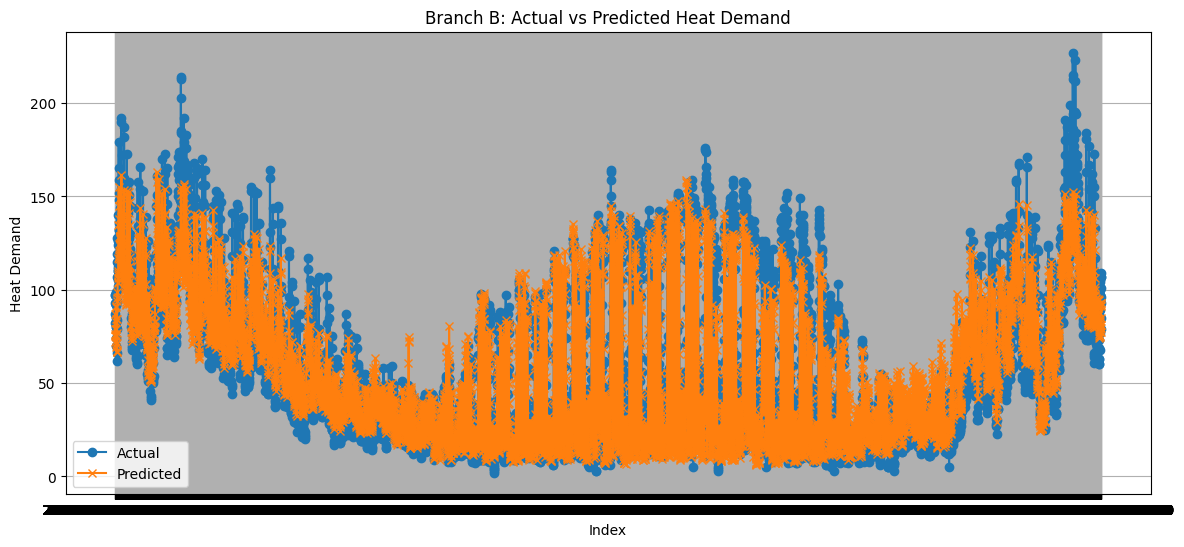

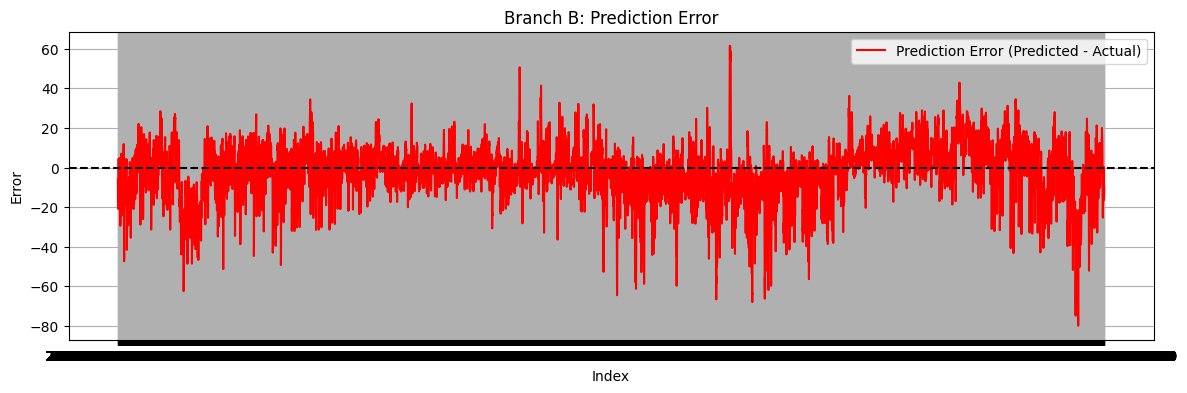

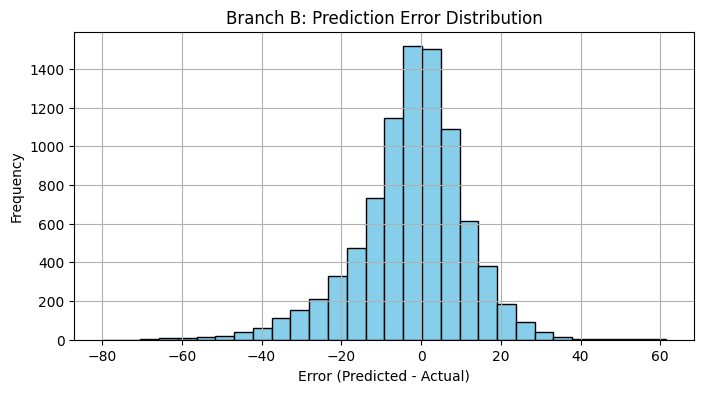

각 Fold의 Validation RMSE: [np.float64(14.773621763757165), np.float64(13.177589900550231)]
최종 평균 Validation RMSE: 13.975605832153697


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 1. branch_id가 'B'인 데이터만 추출
branch = 'E'
train_branch = df_train[df_train['branch_id'] == branch].copy()
test_branch = df_test[df_test['branch_id'] == branch].copy()

# branch_id 컬럼 제거 (모델 입력에 불필요)
train_branch = train_branch.drop(columns=['branch_id'])
test_branch = test_branch.drop(columns=['branch_id'])

target_col = 'heat_demand'

# 2. 예측 수행
results = run_3fold_pipeline_with_residual(train_branch, test_branch, target_col)

# 3. 예측 결과 DataFrame 생성 (index 기준)
test_pred_B = pd.DataFrame({
    'branch_ID': branch,
    'heat_demand': results['test_pred']
}, index=results['test_index'])

# 4. 실제값과 예측값 비교를 위한 df_test_B 준비 (index 기준)
df_test_B = df_test[df_test['branch_id'] == branch].copy()
df_test_B = df_test_B.sort_index()
test_pred_B = test_pred_B.sort_index()

# 5. 공통 인덱스만 사용해서 비교 (NaN 방지)
common_index = df_test_B.index.intersection(test_pred_B.index)
compare_df = df_test_B.loc[common_index, ['heat_demand']].rename(columns={'heat_demand': 'actual'})
compare_df['predicted'] = test_pred_B.loc[common_index, 'heat_demand']
compare_df['diff'] = compare_df['predicted'] - compare_df['actual']

# 6. NaN이 남아있으면 제거
compare_df = compare_df.dropna()

# 7. RMSE, MAE 계산
rmse = np.sqrt(np.mean(compare_df['diff'] ** 2))
mae = np.mean(np.abs(compare_df['diff']))
print(f"Branch B - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# 8. 실제값 vs 예측값 시각화
plt.figure(figsize=(14, 6))
plt.plot(compare_df.index, compare_df['actual'], label='Actual', marker='o')
plt.plot(compare_df.index, compare_df['predicted'], label='Predicted', marker='x')
plt.title('Branch B: Actual vs Predicted Heat Demand')
plt.xlabel('Index')
plt.ylabel('Heat Demand')
plt.legend()
plt.grid(True)
plt.show()

# 9. 오차 시계열 시각화
plt.figure(figsize=(14, 4))
plt.plot(compare_df.index, compare_df['diff'], label='Prediction Error (Predicted - Actual)', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Branch B: Prediction Error')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# 10. 오차 분포 히스토그램
plt.figure(figsize=(8, 4))
plt.hist(compare_df['diff'], bins=30, color='skyblue', edgecolor='black')
plt.title('Branch B: Prediction Error Distribution')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("각 Fold의 Validation RMSE:", results['val_rmses'])
print("최종 평균 Validation RMSE:", results['val_rmse'])

In [7]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=compare_df.index, y=compare_df['actual'],
    mode='lines+markers', name='Actual', marker=dict(symbol='circle', size=5)
))
fig.add_trace(go.Scatter(
    x=compare_df.index, y=compare_df['predicted'],
    mode='lines+markers', name='Predicted', marker=dict(symbol='x', size=5)
))
fig.update_layout(
    title='Branch B: Actual vs Predicted Heat Demand',
    xaxis_title='Index',
    yaxis_title='Heat Demand',
    legend=dict(x=0, y=1),
    template='plotly_white',
    width=900, height=400
)
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=compare_df.index, y=compare_df['diff'],
    mode='lines+markers', name='Prediction Error', marker=dict(color='red', size=5)
))
fig.add_trace(go.Scatter(
    x=compare_df.index, y=[0]*len(compare_df),  # 0선
    mode='lines', name='Zero Line', line=dict(color='black', dash='dash')
))
fig.update_layout(
    title='Branch B: Prediction Error',
    xaxis_title='Index',
    yaxis_title='Error',
    legend=dict(x=0, y=1),
    template='plotly_white',
    width=900, height=300
)
fig.show()